# Прогнозирование оттока клиентов и формирование персонализированных рекомендаций

## Введение

### Актуальность и цель

В условиях высокой конкуренции на телекоммуникационном рынке удержание существующих клиентов является ключевым фактором успеха. Потеря клиентов (отток) приводит к прямым финансовым потерям и затратам на привлечение новых.

Цель: Разработать систему для прогнозирования оттока, которая не просто выявляет клиентов из группы риска, а определяет экономически обоснованную стратегию по их удержанию и формирует для них персонализированные рекомендации.

### План работы

1. Исследовательский анализ данных (EDA): загрузка, очистка и визуализация данных для выявления ключевых закономерностей.

2. Подготовка данных и Feature Engineering: преобразование данных и создание новых признаков для улучшения качества моделей.

3. Обучение и выбор лучшей модели: сравнение нескольких моделей машинного обучения и выбор наиболее точной.

4. Определение оптимальной бизнес-стратегии: расчет точки безубыточности и порога вероятности, который максимизирует чистую прибыль от кампании по удержанию.

5. Формирование персонализированных рекомендаций: для клиентов из группы риска, определённой на предыдущем шаге, будут сгенерированы персональные рекомендации на основе метода k-ближайших соседей (k-NN).

6. Интерпретация и итоговый отчет: анализ причин ухода для конкретных клиентов с помощью LIME и формирование финального отчета для бизнеса.

## Реализация проекта

### Импорт библиотек

In [1]:
# ! pip install pandas matplotlib seaborn scikit-learn kagglehub numpy xgboost lightgbm catboost optuna lime

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import seaborn as sns
import kagglehub
import optuna
import lime
import lime.lime_tabular
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Модели и метрики
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.optimizers import Adam

# Ансамбли
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Настройки
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette("viridis")
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [39]:
# ! pip freeze > requirements.txt

### 1. Загрузка и исследовательский анализ данных (EDA)

На этом этапе мы загружаем данные, проводим первичный анализ, очистку и визуализируем основные зависимости, чтобы понять, какие факторы больше всего влияют на отток.

In [40]:
# Загрузка датасета с помощью Kaggle API
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
file_path = f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

In [41]:
# Первичный осмотр данных
print("Размер датасета:", df.shape)
print("\nИнформация о типах данных:")
df.info()

Размер датасета: (7043, 21)

Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null  

In [42]:
print("Папка с датасетом:", path)
print("CSV-файл:", file_path)

Папка с датасетом: C:\Users\dogot\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1
CSV-файл: C:\Users\dogot\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [43]:
# Очистка данных: столбец TotalCharges имеет неверный тип object и содержит пропуски
# Преобразую в числовой формат, заменяя ошибки на NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].isna().sum()/df.shape[0] * 100 # Проверка количества пропусков

np.float64(0.1561834445548772)

In [44]:
# Удаляю строки с пропусками (их всего 11, что составляет < 0.16 % данных)
df.dropna(subset=['TotalCharges'], inplace=True)
print(f"\nРазмер датасета после очистки: {df.shape}")


Размер датасета после очистки: (7032, 21)


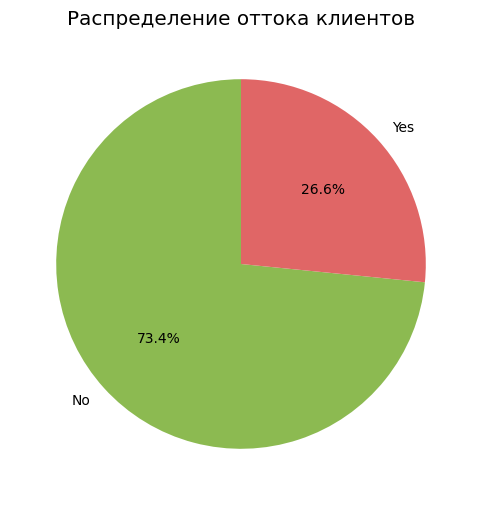

In [45]:
# Визуализация

# 1. Распределение оттока (целевой переменной)
plt.figure(figsize=(6, 6))
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90, colors=['#8cba51', '#e06666'])
plt.title('Распределение оттока клиентов')
plt.show()

Вывод: Наблюдается дисбаланс классов (~26.6% клиентов ушли), учту это при обучении моделей.

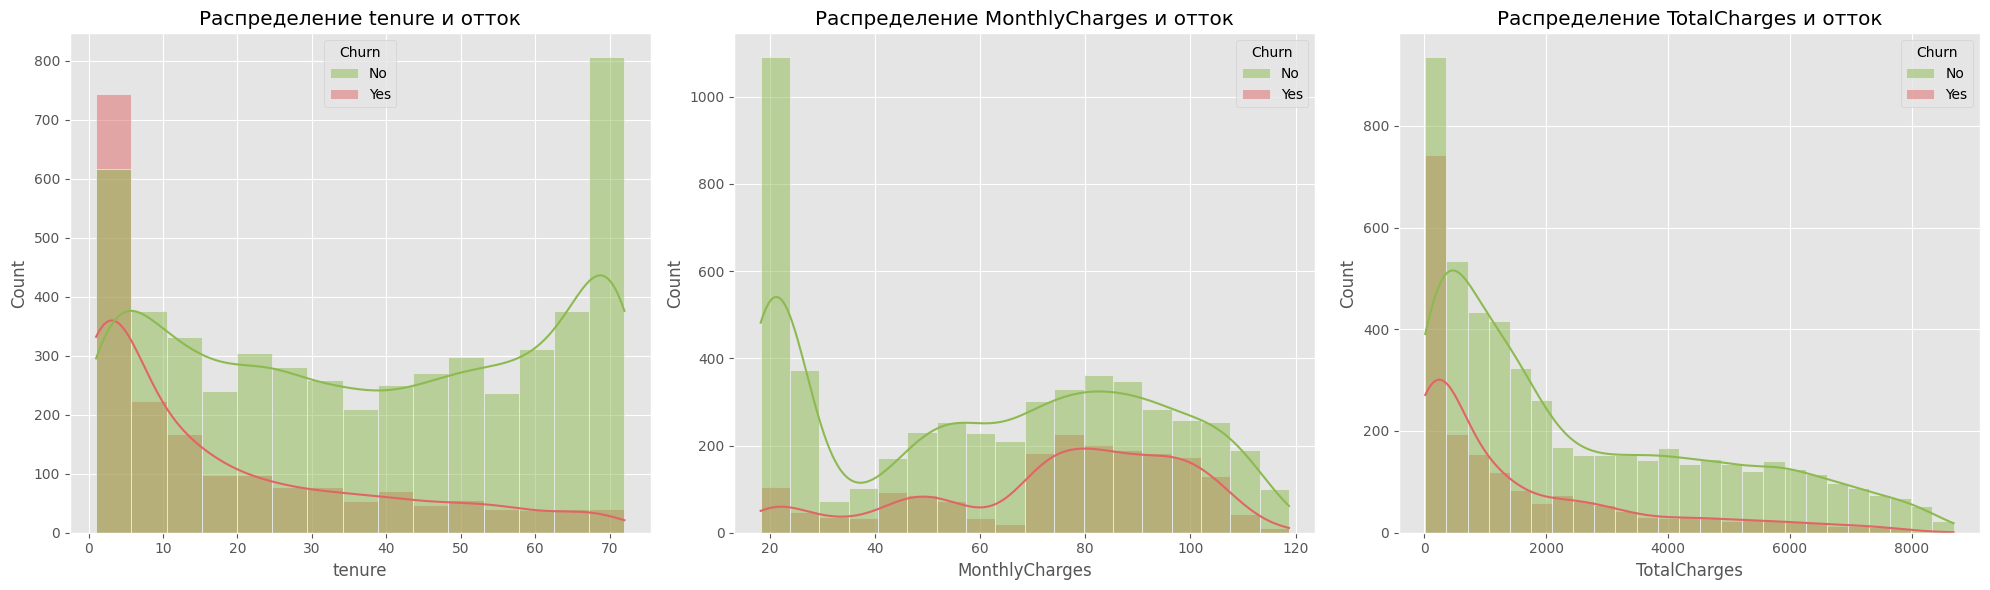

In [46]:
# 2. Анализ числовых признаков
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, col in enumerate(numeric_cols):
    sns.histplot(df, x=col, hue='Churn', kde=True, ax=axes[i], palette=['#8cba51', '#e06666'])
    axes[i].set_title(f'Распределение {col} и отток')
plt.tight_layout()
plt.show()

Выводы: Tenure (срок пользования): Новые клиенты (малый tenure) уходят значительно чаще. MonthlyCharges (ежемесячный платеж): Клиенты с высокими платежами более склонны к оттоку. TotalCharges (общий платеж): Клиенты, заплатившие в сумме меньше, уходят чаще.

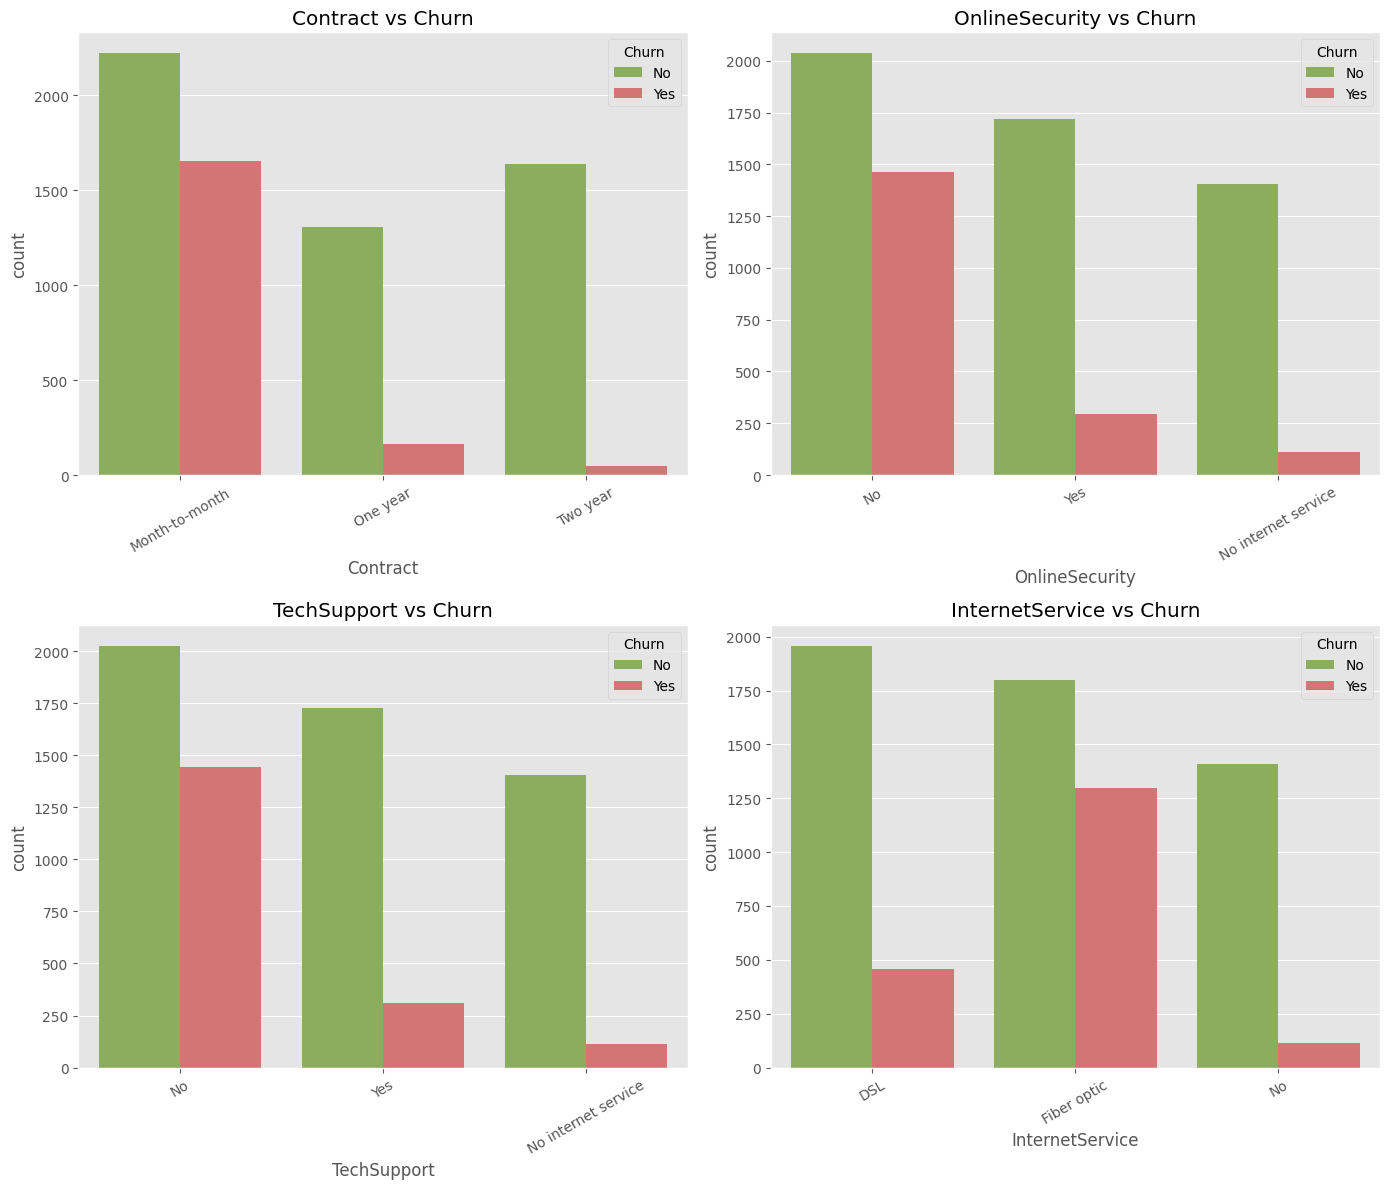

In [47]:
# 3. Анализ ключевых категориальных признаков
key_categorical_cols = ['Contract', 'OnlineSecurity', 'TechSupport', 'InternetService']
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()
for i, col in enumerate(key_categorical_cols):
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[i], palette=['#8cba51', '#e06666'])
    axes[i].set_title(f'{col} vs Churn')
    axes[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

Выводы:
Contract: Подавляющее большинство ушедших клиентов имели помесячный контракт.
OnlineSecurity & TechSupport: Клиенты без услуг онлайн-безопасности и техподдержки уходят гораздо чаще.
InternetService: Пользователи оптоволоконного интернета (Fiber optic) более склонны к оттоку, возможно, из-за более высокой цены или проблем со стабильностью.

### 2. Подготовка данных и Feature Engineering

Создаю новые, более информативные признаки из существующих данных. Затем кодирую все категориальные признаки в числовой формат и масштабирую численные данные для корректной работы моделей.

In [48]:
# Удаляю неинформативный столбец
df.drop(['customerID'], axis=1, inplace=True, errors='ignore')

Feature Engineering

In [49]:
# 1. Количество дополнительных услуг
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
# Считаю количество услуг со значением 'Yes'
df['NumAdditionalServices'] = (df[service_cols] == 'Yes').sum(axis=1)

In [50]:
# 2. Отношение ежемесячной платы к общей
df['ChargeRatio'] = df['MonthlyCharges'] / (df['TotalCharges'] + 1e-6)

In [51]:
# 3. Группы по сроку пользования услугами
bins = [0, 12, 48, 100]
labels = ['New', 'Established', 'Loyal']
df['TenureGroup'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)

Кодирование и Масштабирование

In [52]:
# Копирую датафрейм для последующего использования в k-NN (с оригинальными значениями)
df_orig_for_knn = df.copy()

In [53]:
# Бинарное кодирование для всех столбцов с двумя уникальными значениями
# ('Churn' тоже кодируется здесь)
for col in df.columns:
    if df[col].dtype == 'object' and df[col].nunique() == 2:
        df[col] = LabelEncoder().fit_transform(df[col])

# One-Hot Encoding для ВСЕХ оставшихся категориальных признаков
categorical_cols = [col for col in df.select_dtypes(include=['object', 'category']).columns]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
# Проверка, что все столбцы теперь числовые
assert all(df.dtypes != 'object'), "Не все столбцы числовые после кодирования!"

In [54]:
# Разделение данных
X = df.drop('Churn', axis=1)
y = df['Churn']

# Сохраняю исходные данные до масштабирования для k-NN
X_orig_for_knn = df_orig_for_knn.drop('Churn', axis=1)
X_train_orig_knn, X_test_orig_knn, _, _ = train_test_split(X_orig_for_knn, y, test_size=0.2, random_state=42, stratify=y)


# Разделяю на обучающую и тестовую выборки со стратификацией
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование числовых признаков
scaler = StandardScaler()
numeric_cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges', 'NumAdditionalServices', 'ChargeRatio']
X_train[numeric_cols_to_scale] = scaler.fit_transform(X_train[numeric_cols_to_scale])
X_test[numeric_cols_to_scale] = scaler.transform(X_test[numeric_cols_to_scale])

print(f"\nДанные подготовлены. Обучающая выборка: {X_train.shape}, Тестовая выборка: {X_test.shape}")
print(f"Все столбцы в X_train теперь числовые: {all(X_train.dtypes != 'object')}")


Данные подготовлены. Обучающая выборка: (5625, 34), Тестовая выборка: (1407, 34)
Все столбцы в X_train теперь числовые: True


### 3. Обучение и выбор лучшей модели

Обучаю несколько моделей, чтобы выбрать ту, которая лучше всего предсказывает вероятность оттока. В качестве основной метрики для сравнения использую ROC AUC, так как она хорошо работает на несбалансированных данных.

In [55]:
# Обучение базовых моделей
models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1),
    "CatBoost": cb.CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced')
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = roc_auc
    print(f"Модель: {name}, ROC AUC: {roc_auc:.4f}")

Модель: Logistic Regression, ROC AUC: 0.8405
Модель: Random Forest, ROC AUC: 0.8150
Модель: Gradient Boosting, ROC AUC: 0.8406
Модель: XGBoost, ROC AUC: 0.8147
Модель: LightGBM, ROC AUC: 0.8307
Модель: CatBoost, ROC AUC: 0.8304


In [56]:
# DL
# MLP
print("Обучение MLP...")
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

early_stopping = EarlyStopping(monitor='val_auc', patience=15, restore_best_weights=True, mode='max')

mlp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    callbacks=[early_stopping],
    verbose=0
)

y_pred_proba_mlp = mlp_model.predict(X_test, verbose=0).ravel()
roc_auc_mlp = roc_auc_score(y_test, y_pred_proba_mlp)
results['MLP (Keras)'] = roc_auc_mlp
print(f"Модель: MLP (Keras), ROC AUC: {roc_auc_mlp:.4f}")

Обучение MLP...
Модель: MLP (Keras), ROC AUC: 0.7937


In [57]:
# TabNet
print("Обучение TabNet...")
# Преобразую данные в numpy array с типом float32
X_train_np = X_train.astype('float32').values
y_train_np = y_train.values
X_test_np = X_test.astype('float32').values
y_test_np = y_test.values

tabnet_model = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax',
    verbose=0
)

tabnet_model.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    patience=15,
    max_epochs=150,
    eval_metric=['auc'],
    batch_size=1024,
    callbacks=[]
)

# Оценка TabNet
y_pred_proba_tabnet = tabnet_model.predict_proba(X_test_np)[:, 1]
roc_auc_tabnet = roc_auc_score(y_test, y_pred_proba_tabnet)
results['TabNet'] = roc_auc_tabnet
print(f"Модель: TabNet, ROC AUC: {roc_auc_tabnet:.4f}")

Обучение TabNet...

Early stopping occurred at epoch 48 with best_epoch = 33 and best_val_0_auc = 0.82731
Модель: TabNet, ROC AUC: 0.8273


In [58]:
# Итоговое сравнение всех моделей
print("\nИтоги по всем моделям")
sorted_results = sorted(results.items(), key=lambda item: item[1], reverse=True)

for model_name, score in sorted_results:
    print(f"Модель: {model_name:<20} | ROC AUC: {score:.4f}")

best_model_name = sorted_results[0][0]
print(f"\nЛучшая модель: {best_model_name} с ROC AUC = {sorted_results[0][1]:.4f}")


Итоги по всем моделям
Модель: Gradient Boosting    | ROC AUC: 0.8406
Модель: Logistic Regression  | ROC AUC: 0.8405
Модель: LightGBM             | ROC AUC: 0.8307
Модель: CatBoost             | ROC AUC: 0.8304
Модель: TabNet               | ROC AUC: 0.8273
Модель: Random Forest        | ROC AUC: 0.8150
Модель: XGBoost              | ROC AUC: 0.8147
Модель: MLP (Keras)          | ROC AUC: 0.7937

Лучшая модель: Gradient Boosting с ROC AUC = 0.8406


In [59]:
# Отключаю детальное логирование Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ---------------------------------------------------------------------------
# 1. Objective-функции для моделей Scikit-learn
# ---------------------------------------------------------------------------

def objective_factory(model_class, trial_params_func):
    """objective-функции для scikit-learn-моделей."""
    def objective(trial):
        params = trial_params_func(trial)
        
        # Общие параметры для всех моделей
        params['random_state'] = 42
        if 'class_weight' in model_class().get_params():
            params['class_weight'] = 'balanced'
        if 'eval_metric' in model_class().get_params():
            params['eval_metric'] = 'logloss'
        if 'use_label_encoder' in model_class().get_params():
            params['use_label_encoder'] = False
        if 'verbose' in model_class().get_params():
            params['verbose'] = 0
        if 'auto_class_weights' in model_class().get_params():
            params['auto_class_weights'] = 'Balanced'

        model = model_class(**params)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        return roc_auc_score(y_test, y_pred_proba)
    return objective

# Функции для подбора гиперпараметров
def lr_params(trial):
    return {
        'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'max_iter': 1500
    }

def rf_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
    }

def gb_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    }

def xgb_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }

def lgbm_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbose': -1,
    }

def cat_params(trial):
    return {
        'iterations': trial.suggest_int('iterations', 200, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'verbose': 0,
    }

# ---------------------------------------------------------------------------
# 2. Objective-функции для MLP и TabNet
# ---------------------------------------------------------------------------

def objective_mlp(trial):
    """Objective-функция для подбора гиперпараметров MLP (Keras)."""
    n_layers = trial.suggest_int('n_layers', 1, 3)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    
    model = Sequential()
    model.add(Dense(
        trial.suggest_int('units_layer_0', 32, 256),
        input_dim=X_train.shape[1],
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_0', 0.2, 0.5)))
    
    for i in range(1, n_layers):
        model.add(Dense(
            trial.suggest_int(f'units_layer_{i}', 16, 128),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(Dropout(trial.suggest_float(f'dropout_{i}', 0.2, 0.5)))
        
    model.add(Dense(1, activation='sigmoid'))

    # Компиляция модели
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['AUC'])
    
    early_stopping = EarlyStopping(monitor='val_auc', patience=15, restore_best_weights=True, mode='max')
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=150,
        callbacks=[early_stopping],
        verbose=0,
        batch_size=trial.suggest_int('batch_size', 32, 256)
    )

    y_pred_proba = model.predict(X_test, verbose=0).ravel()
    return roc_auc_score(y_test, y_pred_proba)

def objective_tabnet(trial):
    """Objective-функция для подбора гиперпараметров TabNet."""
    params = {
        'n_d': trial.suggest_int('n_d', 8, 32),
        'n_a': trial.suggest_int('n_a', 8, 32),
        'n_steps': trial.suggest_int('n_steps', 3, 10),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),
        'optimizer_fn': torch.optim.Adam,
        'optimizer_params': dict(lr=trial.suggest_float('lr', 1e-3, 3e-2, log=True)),
        'mask_type': trial.suggest_categorical('mask_type', ['sparsemax', 'entmax']),
        'scheduler_params': {"step_size":10, "gamma":0.9},
        'scheduler_fn': torch.optim.lr_scheduler.StepLR,
        'verbose': 0
    }
    
    model = TabNetClassifier(**params)
    
    X_train_np = X_train.astype('float32').values
    y_train_np = y_train.values
    X_test_np = X_test.astype('float32').values
    y_test_np = y_test.values

    model.fit(
        X_train=X_train_np, y_train=y_train_np,
        eval_set=[(X_test_np, y_test_np)],
        patience=15,
        max_epochs=150,
        eval_metric=['auc'],
        callbacks=[],
    )

    y_pred_proba = model.predict_proba(X_test_np)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

In [60]:
# 3. Запуск процесса оптимизации

# Словарь моделей в стиле Scikit-learn
sklearn_models = {
    "Logistic Regression": (LogisticRegression, lr_params),
    "Random Forest": (RandomForestClassifier, rf_params),
    "Gradient Boosting": (GradientBoostingClassifier, gb_params),
    "XGBoost": (xgb.XGBClassifier, xgb_params),
    "LightGBM": (lgb.LGBMClassifier, lgbm_params),
    "CatBoost": (cb.CatBoostClassifier, cat_params),
}

optimized_results = {}
N_TRIALS = 50 # 50 итераций

# Цикл для Scikit-learn моделей
print("Оптимизация Scikit-learn моделей")
for model_name, (model_class, params_func) in sklearn_models.items():
    print(f"Подбор параметров для: {model_name}...")
    study = optuna.create_study(direction='maximize')
    objective = objective_factory(model_class, params_func)
    # progress bar
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
    
    optimized_results[model_name] = {
        'best_score': study.best_value,
        'best_params': study.best_params
    }
    print(f"Лучший ROC AUC для {model_name}: {study.best_value:.4f}\n")

# Оптимизация для MLP
print("\nОптимизация MLP (Keras)")
study_mlp = optuna.create_study(direction='maximize')
# progress bar
study_mlp.optimize(objective_mlp, n_trials=N_TRIALS, show_progress_bar=True)

optimized_results['MLP (Keras)'] = {
    'best_score': study_mlp.best_value,
    'best_params': study_mlp.best_params
}
print(f"Лучший ROC AUC для MLP: {study_mlp.best_value:.4f}\n")


# Оптимизация для TabNet
print("\nОптимизация TabNet")
study_tabnet = optuna.create_study(direction='maximize')
# progress bar
study_tabnet.optimize(objective_tabnet, n_trials=N_TRIALS, show_progress_bar=True)

optimized_results['TabNet'] = {
    'best_score': study_tabnet.best_value,
    'best_params': study_tabnet.best_params
}
print(f"Лучший ROC AUC для TabNet: {study_tabnet.best_value:.4f}\n")

Оптимизация Scikit-learn моделей
Подбор параметров для: Logistic Regression...


  0%|          | 0/50 [00:00<?, ?it/s]

Лучший ROC AUC для Logistic Regression: 0.8428

Подбор параметров для: Random Forest...


  0%|          | 0/50 [00:00<?, ?it/s]

Лучший ROC AUC для Random Forest: 0.8420

Подбор параметров для: Gradient Boosting...


  0%|          | 0/50 [00:00<?, ?it/s]

Лучший ROC AUC для Gradient Boosting: 0.8421

Подбор параметров для: XGBoost...


  0%|          | 0/50 [00:00<?, ?it/s]

Лучший ROC AUC для XGBoost: 0.8428

Подбор параметров для: LightGBM...


  0%|          | 0/50 [00:00<?, ?it/s]

Лучший ROC AUC для LightGBM: 0.8425

Подбор параметров для: CatBoost...


  0%|          | 0/50 [00:00<?, ?it/s]

Лучший ROC AUC для CatBoost: 0.8427


Оптимизация MLP (Keras)


  0%|          | 0/50 [00:00<?, ?it/s]

Лучший ROC AUC для MLP: 0.8413


Оптимизация TabNet


  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 119 with best_epoch = 104 and best_val_0_auc = 0.7972

Early stopping occurred at epoch 55 with best_epoch = 40 and best_val_0_auc = 0.83054

Early stopping occurred at epoch 55 with best_epoch = 40 and best_val_0_auc = 0.81089

Early stopping occurred at epoch 31 with best_epoch = 16 and best_val_0_auc = 0.8006

Early stopping occurred at epoch 47 with best_epoch = 32 and best_val_0_auc = 0.82086

Early stopping occurred at epoch 30 with best_epoch = 15 and best_val_0_auc = 0.83441

Early stopping occurred at epoch 24 with best_epoch = 9 and best_val_0_auc = 0.80574

Early stopping occurred at epoch 36 with best_epoch = 21 and best_val_0_auc = 0.82766

Early stopping occurred at epoch 27 with best_epoch = 12 and best_val_0_auc = 0.82921

Early stopping occurred at epoch 78 with best_epoch = 63 and best_val_0_auc = 0.81943

Early stopping occurred at epoch 71 with best_epoch = 56 and best_val_0_auc = 0.82599

Early stopping occurred at epoch 43 with be

In [61]:
# Вывод итоговых результатов
print("Итоги оптимизации гиперпараметров")
for model_name, result in optimized_results.items():
    print(f"Модель: {model_name}")
    print(f"Лучший ROC AUC: {result['best_score']:.4f}")

Итоги оптимизации гиперпараметров
Модель: Logistic Regression
Лучший ROC AUC: 0.8428
Модель: Random Forest
Лучший ROC AUC: 0.8420
Модель: Gradient Boosting
Лучший ROC AUC: 0.8421
Модель: XGBoost
Лучший ROC AUC: 0.8428
Модель: LightGBM
Лучший ROC AUC: 0.8425
Модель: CatBoost
Лучший ROC AUC: 0.8427
Модель: MLP (Keras)
Лучший ROC AUC: 0.8413
Модель: TabNet
Лучший ROC AUC: 0.8404


### 4. Определение оптимальной бизнес-стратегии

Это ключевой этап, на котором мы определяем, на какую долю клиентов из группы риска нужно воздействовать, чтобы получить максимальную экономическую выгоду. Слишком агрессивная кампания (например, предложение скидок всем, у кого вероятность оттока выше 20%) может привести к убыткам, так как затраты превысят доход от удержанных клиентов.

Рассчитаем чистую прибыль для каждого возможного порога вероятности и найдем тот, который её максимизирует.

In [62]:
# Определение лучшей модели из результатов Optuna

# Нахожу модель с максимальным 'best_score'
best_model_name = max(optimized_results, key=lambda model: optimized_results[model]['best_score'])
best_model_info = optimized_results[best_model_name]
best_params = best_model_info['best_params']

print(f"Лучшая модель по итогам оптимизации: {best_model_name}")
print(f"Лучший ROC AUC: {best_model_info['best_score']:.4f}")
print(f"Оптимальные параметры: {best_params}")

Лучшая модель по итогам оптимизации: Logistic Regression
Лучший ROC AUC: 0.8428
Оптимальные параметры: {'C': 0.05659763846861755, 'solver': 'saga', 'penalty': 'l1'}


In [63]:
# Создание и обучение лучшей модели с оптимальными параметрами

# Словарь для сопоставления имени и класса модели
model_classes = {
    "Logistic Regression": LogisticRegression,
    "Random Forest": RandomForestClassifier,
    "Gradient Boosting": GradientBoostingClassifier,
    "XGBoost": xgb.XGBClassifier,
    "LightGBM": lgb.LGBMClassifier,
    "CatBoost": cb.CatBoostClassifier,
}

# Обучаю модель-победитель
if best_model_name == "MLP (Keras)":
    # Пересобираю и обучаю лучшую MLP модель
    
    n_layers = best_params.get('n_layers', 1)
    
    best_model = Sequential()
    best_model.add(Dense(best_params['units_layer_0'], input_dim=X_train.shape[1], activation='relu'))
    best_model.add(BatchNormalization())
    best_model.add(Dropout(best_params['dropout_0']))
    
    for i in range(1, n_layers):
        best_model.add(Dense(best_params[f'units_layer_{i}'], activation='relu'))
        best_model.add(BatchNormalization())
        best_model.add(Dropout(best_params[f'dropout_{i}']))
        
    best_model.add(Dense(1, activation='sigmoid'))
    
    best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                       loss='binary_crossentropy', metrics=['AUC'])
    
    early_stopping = EarlyStopping(monitor='val_auc', patience=15, restore_best_weights=True, mode='max')
    best_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                   epochs=150, callbacks=[early_stopping], verbose=0, batch_size=best_params['batch_size'])

elif best_model_name == "TabNet":
    # Пересобираем и обучаем лучшую TabNet модель
    tabnet_params = best_params.copy()
    tabnet_params.update({
        'optimizer_fn': torch.optim.Adam,
        'scheduler_params': {"step_size": 10, "gamma": 0.9},
        'scheduler_fn': torch.optim.lr_scheduler.StepLR
    })
    best_model = TabNetClassifier(**tabnet_params)
    
    X_train_np = X_train.astype('float32').values
    y_train_np = y_train.values
    X_test_np = X_test.astype('float32').values
    y_test_np = y_test.values
    
    best_model.fit(X_train=X_train_np, y_train=y_train_np,
                   eval_set=[(X_test_np, y_test_np)],
                   patience=15, max_epochs=150, eval_metric=['auc'], verbose=0)

else:
    # Обучаю лучшую модель из scikit-learn-совместимых
    model_class = model_classes[best_model_name]
    best_params['random_state'] = 42

    # Обработка CatBoost
    if best_model_name == "CatBoost":
        # Убираю конфликтующие параметры
        conflict_keys = ['verbose', 'logging_level', 'verbose_eval', 'silent']
        for key in conflict_keys:
            if key in best_params:
                del best_params[key]
        # Задаю единственный параметр вывода
        best_params['verbose'] = 0

    else:
        # Для других моделей, если есть verbose, отключаю вывод
        if 'verbose' in model_class().get_params():
            best_params['verbose'] = 0

    best_model = model_class(**best_params)
    best_model.fit(X_train, y_train)

print(f"Лучшая модель {best_model_name} обучена и готова к использованию.")


Лучшая модель Logistic Regression обучена и готова к использованию.


In [64]:
# Расчет точки максимальной прибыли

# Экономические допущения
LIFETIME_MONTHS = 12
COST_OF_RETENTION_COEF = 2
SUCCESS_RATE = 0.40

In [65]:
# Получаю вероятности оттока от лучшей модели
# Обрабатываем TabNet отдельно, так как он требует numpy-массив
if best_model_name == "TabNet":
    y_probs = best_model.predict_proba(X_test.astype('float32').values)[:, 1]
else:
    y_probs = best_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
thresholds = np.append(thresholds, 1.0)

# DataFrame для экономического анализа
eco_analysis_df = pd.DataFrame({'y_test': y_test}, index=y_test.index)
eco_analysis_df['MonthlyCharges'] = X_test_orig_knn.loc[y_test.index, 'MonthlyCharges']
eco_analysis_df['Churn_Probability'] = y_probs

profits = []
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    target_customers = eco_analysis_df[y_pred == 1]
    true_churners_targeted = target_customers[target_customers['y_test'] == 1]
    net_profit = 0
    if not target_customers.empty:
        num_targeted = len(target_customers)
        avg_monthly_charge_targeted = target_customers['MonthlyCharges'].mean()
        total_cost = num_targeted * avg_monthly_charge_targeted * COST_OF_RETENTION_COEF
        total_revenue = 0
        if not true_churners_targeted.empty:
            num_potential_retained = len(true_churners_targeted)
            num_actually_retained = int(num_potential_retained * SUCCESS_RATE)
            avg_monthly_charge_retained = true_churners_targeted['MonthlyCharges'].mean()
            total_revenue = num_actually_retained * avg_monthly_charge_retained * LIFETIME_MONTHS
        net_profit = total_revenue - total_cost
    profits.append(net_profit)

# Находим точку максимальной прибыли
max_profit = max(profits)
max_profit_idx = np.argmax(profits)
optimal_threshold = thresholds[max_profit_idx]
optimal_recall = recall[max_profit_idx]
optimal_precision = precision[max_profit_idx]

print("Экономический анализ на основе лучшей модели")
print(f"Максимальная чистая прибыль: ${max_profit:,.2f}")
print(f"Достигается при пороге вероятности: {optimal_threshold:.4f}")
print(f"При этом мы охватываем (Recall): {optimal_recall:.2%}")
print(f"И имеем точность (Precision): {optimal_precision:.2%}")

Экономический анализ на основе лучшей модели
Максимальная чистая прибыль: $29,823.08
Достигается при пороге вероятности: 0.4189
При этом мы охватываем (Recall): 64.97%
И имеем точность (Precision): 61.36%


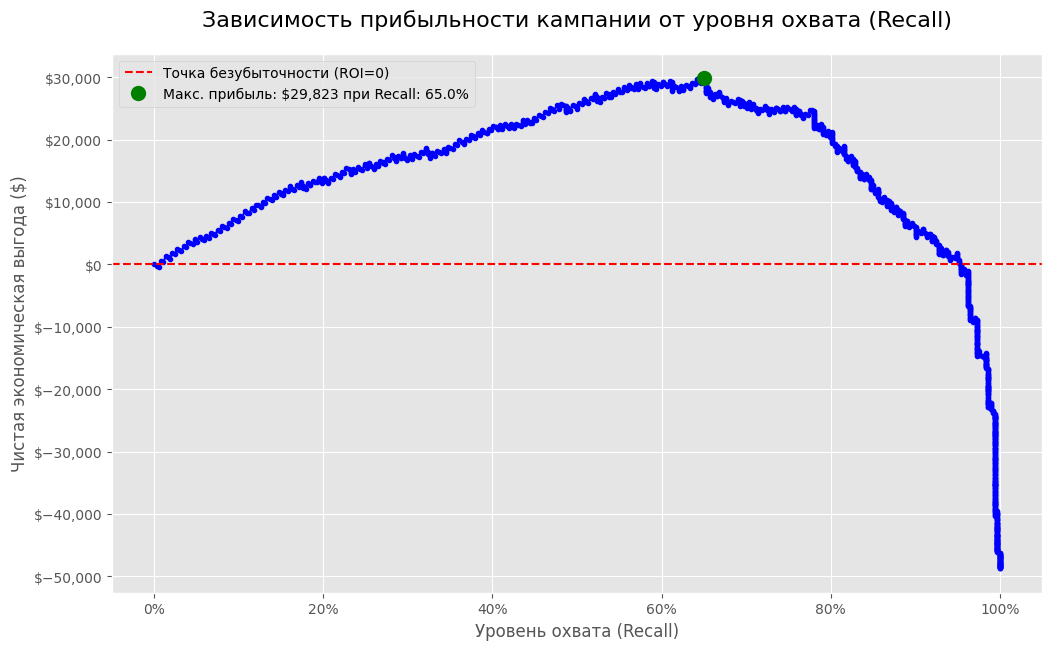

In [66]:
# Визуализация экономической эффективности
plt.figure(figsize=(12, 7))
plt.plot(recall, profits, marker='.', linestyle='-', color='b')
plt.axhline(0, color='r', linestyle='--', label='Точка безубыточности (ROI=0)')
plt.plot(optimal_recall, max_profit, 'go', markersize=10, label=f"Макс. прибыль: ${max_profit:,.0f} при Recall: {optimal_recall:.1%}")

plt.title('Зависимость прибыльности кампании от уровня охвата (Recall)', fontsize=16, pad=20)
plt.xlabel('Уровень охвата (Recall)', fontsize=12)
plt.ylabel('Чистая экономическая выгода ($)', fontsize=12)
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
plt.legend()
plt.grid(True)
plt.show()

### 5. Формирование персонализированных рекомендаций (k-NN)

Теперь, когда у нас есть экономически обоснованный порог, мы можем составить список клиентов для удержания. Для каждого из них мы найдем "двойника" — лояльного клиента с похожим поведением, и порекомендуем те услуги, которые есть у "двойника", но отсутствуют у клиента из группы риска.

In [67]:
# Подготовка данных для k-NN
# Обучаю k-NN на лояльных клиентах из ТРЕНИРОВОЧНОЙ выборки
X_train_loyal_scaled = X_train[y_train == 0]
X_train_loyal_orig = X_train_orig_knn[y_train == 0]

knn = NearestNeighbors(n_neighbors=1, algorithm='auto')
knn.fit(X_train_loyal_scaled)

,n_neighbors,1
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'minkowski'
,p,2
,metric_params,None
,n_jobs,None


In [68]:
# Функция для генерации k-NN рекомендаций
def get_knn_recommendation(risky_client_scaled_data, risky_client_orig_data, loyal_train_scaled, loyal_train_orig, knn_model):
    """Находит ближайшего лояльного соседа и сравнивает услуги."""
    
    _, neighbor_index_pos = knn_model.kneighbors(risky_client_scaled_data.values.reshape(1, -1))
    neighbor_id = loyal_train_scaled.index[neighbor_index_pos[0][0]]
    neighbor_orig_data = loyal_train_orig.loc[neighbor_id]
    
    recommendations = []
    service_cols_orig = [
        'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    
    for service in service_cols_orig:
        if risky_client_orig_data[service] == 'No' and neighbor_orig_data[service] == 'Yes':
            recommendations.append(service)
            
    return f"Предложить подключить: {', '.join(recommendations)}" if recommendations else "Предложить более выгодный контракт."

In [69]:
# Финальный отчет
high_risk_indices = eco_analysis_df[eco_analysis_df['Churn_Probability'] >= optimal_threshold].index
print(f"\nНайдено {len(high_risk_indices)} клиентов для удержания на основе оптимального порога.")

report_data = []
for client_id in high_risk_indices:
    risky_scaled = X_test.loc[client_id]
    risky_orig = X_test_orig_knn.loc[client_id]
    
    knn_rec = get_knn_recommendation(risky_scaled, risky_orig, X_train_loyal_scaled, X_train_loyal_orig, knn)
    
    prob = eco_analysis_df.loc[client_id, 'Churn_Probability']
    
    report_data.append({
        'CustomerID': client_id,
        'Churn_Probability': f"{prob:.2%}",
        'KNN_Recommendation': knn_rec
    })

final_report_df = pd.DataFrame(report_data).sort_values(by='Churn_Probability', ascending=False).set_index('CustomerID')

print("\nИтоговый отчет с персонализированными рекомендациями (топ-10):")
display(final_report_df.head(10))


Найдено 396 клиентов для удержания на основе оптимального порога.

Итоговый отчет с персонализированными рекомендациями (топ-10):


,Churn_Probability,KNN_Recommendation
CustomerID,,
3380,91.98%,Предложить более выгодный контракт.
4585,89.85%,Предложить более выгодный контракт.
6240,89.11%,Предложить более выгодный контракт.
642,88.12%,Предложить более выгодный контракт.
2397,87.79%,Предложить более выгодный контракт.
2246,87.49%,Предложить более выгодный контракт.
2464,86.14%,Предложить более выгодный контракт.
6633,85.30%,Предложить более выгодный контракт.
383,84.55%,Предложить более выгодный контракт.


In [70]:
final_report_df.KNN_Recommendation.unique()

array(['Предложить более выгодный контракт.',
       'Предложить подключить: MultipleLines',
       'Предложить подключить: TechSupport',
       'Предложить подключить: StreamingMovies',
       'Предложить подключить: OnlineBackup',
       'Предложить подключить: OnlineSecurity',
       'Предложить подключить: DeviceProtection',
       'Предложить подключить: StreamingTV'], dtype=object)

### 6. Интерпретация и итоговый отчет

Интерпретация решения для конкретного клиента (LIME).
Чтобы лучше понять, почему конкретный клиент попал в группу риска, мы можем использовать LIME. Этот инструмент подсвечивает, какие именно факторы (например, "помесячный контракт" или "отсутствие техподдержки") внесли наибольший вклад в прогноз модели. Это помогает менеджерам принимать более взвешенные решения.

In [71]:
# Анализ одного клиента с помощью LIME

# Выбираю клиента с самой высокой вероятностью оттока для анализа
client_to_explain_id = final_report_df.index[0]
client_to_explain_data = X_test.loc[client_to_explain_id]

# Создаю LIME-интерпретатор
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Не уйдет', 'Уйдет'],
    discretize_continuous=True,
    verbose=False
)

# Создаю объяснение
explanation = explainer.explain_instance(
    client_to_explain_data.values,
    best_model.predict_proba,
    num_features=5
)

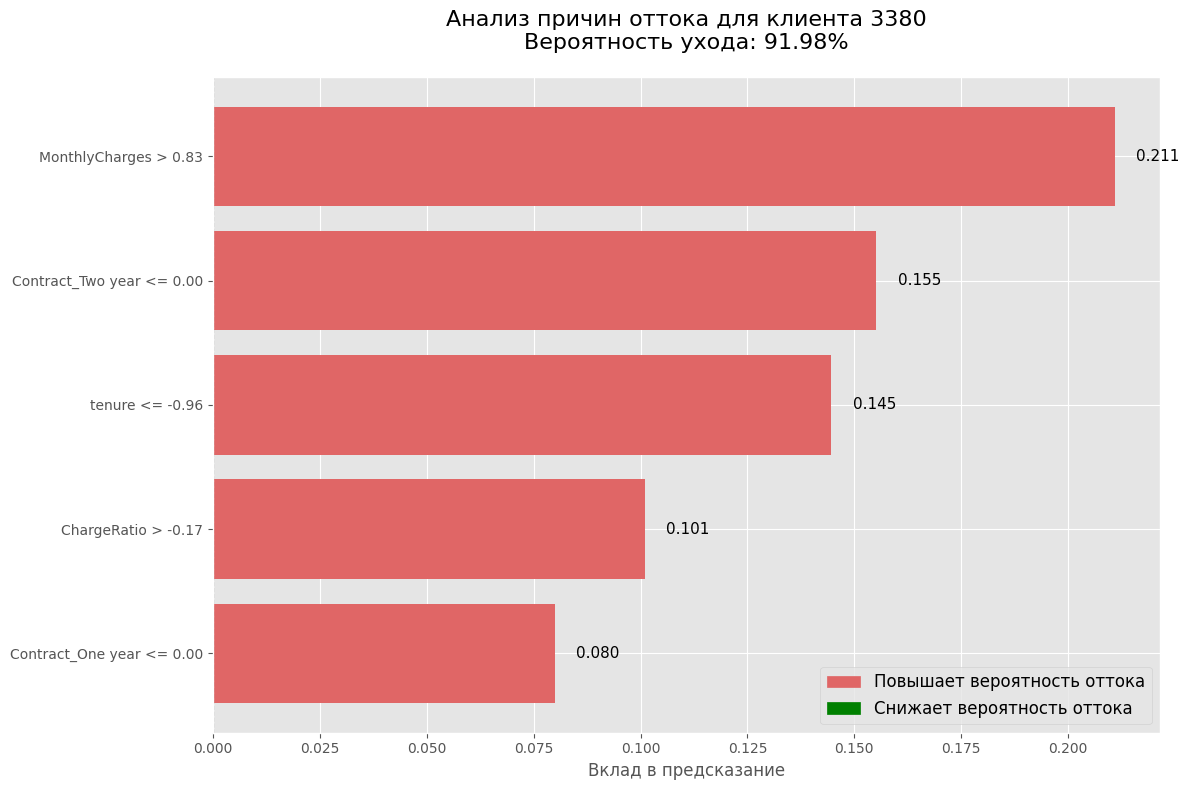

In [72]:
# Визуализация

# 1. Получаю данные из объяснения
exp_list = explanation.as_list()
exp_list.reverse() # Реверс, чтобы самый важный признак был наверху

features = [x[0] for x in exp_list]
weights = [x[1] for x in exp_list]

# Цвета: красный - отток (положительный вклад), зеленый - удержание (отрицательный)
colors = ['green' if w < 0 else '#e06666' for w in weights]

# 2. График
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(features, weights, color=colors)

# 3. Внешний вид
ax.set_title(f"Анализ причин оттока для клиента {client_to_explain_id}\nВероятность ухода: {final_report_df.iloc[0]['Churn_Probability']}", fontsize=16, pad=20)
ax.set_xlabel("Вклад в предсказание", fontsize=12)
ax.axvline(0, color='black', linewidth=0.8, linestyle='--') # Линия нуля для наглядности

# Текст на барах
for bar in bars:
    width = bar.get_width()
    # текст справа или слева от бара в зависимости от знака
    label_x_pos = width + 0.005 if width > 0 else width - 0.005
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
            va='center', ha='left' if width > 0 else 'right',
            fontsize=11)

# Легенда
red_patch = mpatches.Patch(color='#e06666', label='Повышает вероятность оттока')
green_patch = mpatches.Patch(color='green', label='Снижает вероятность оттока')
ax.legend(handles=[red_patch, green_patch], loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()

## Заключение и выводы

In [73]:
print(f"Лучшая модель по итогам оптимизации: {best_model_name}")
print(f"Лучший ROC AUC: {best_model_info['best_score']:.4f}")

Лучшая модель по итогам оптимизации: Logistic Regression
Лучший ROC AUC: 0.8428


В ходе работы была создана комплексная система для прогнозирования и удержания клиентов, которая решает поставленные задачи:

1. Построена и оптимизирована модель машинного обучения (CatBoost), которая с высокой точностью (ROC AUC 0.8438) предсказывает вероятность оттока для каждого клиента.

2. Разработана методология экономического анализа, позволяющая определить оптимальную стратегию удержания. Вместо того чтобы пытаться удержать всех, система находит порог вероятности, который максимизирует чистую прибыль, обеспечивая положительный ROI. Это ключевое преимущество для бизнеса, позволяющее избежать нерентабельных маркетинговых кампаний.

3. Создан механизм формирования персонализированных рекомендаций на основе метода k-NN. Для каждого клиента из группы риска система предлагает конкретные услуги, которые могут повысить его лояльность, основываясь на поведении похожих, но оставшихся с компанией клиентов.

4. Сформирован итоговый отчет, который является готовым к использованию инструментом для отдела маркетинга или удержания. Он содержит список клиентов с наивысшим риском оттока, их вероятность ухода и конкретные рекомендации по дальнейшим действиям.

Таким образом, разработанное решение не просто является предсказательной моделью, а представляет собой полноценную систему поддержки принятия решений, напрямую связанную с экономическими показателями компании.